In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Data

In [31]:
column_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PATRATIO','B','LSTAT','MEDV']

raw_df = pd.read_csv('Bouston house Price Prediction.csv',header = None,delimiter= r"\s+",names=column_names)

In [32]:
raw_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PATRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [33]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CRIM      506 non-null    float64
 1   ZN        506 non-null    float64
 2   INDUS     506 non-null    float64
 3   CHAS      506 non-null    int64  
 4   NOX       506 non-null    float64
 5   RM        506 non-null    float64
 6   AGE       506 non-null    float64
 7   DIS       506 non-null    float64
 8   RAD       506 non-null    int64  
 9   TAX       506 non-null    float64
 10  PATRATIO  506 non-null    float64
 11  B         506 non-null    float64
 12  LSTAT     506 non-null    float64
 13  MEDV      506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [34]:
numeric_column = ['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD','TAX','PATRATIO','B','LSTAT']

## Some Visualization

In [35]:
# Checking for distribution
import seaborn as sns
def dist_check(dataset,column_list,rows,cols,suptitle):
    fig, axs = plt.subplots(rows,cols,figsize = (16,16))
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(suptitle,y=1,size = 20)
    axs = axs.flatten()
    for i,data in enumerate(column_list):
        sns.kdeplot(dataset[data],ax=axs[i],fill=True,alpha=0.5,linewidth=0)
        axs[i].set_title(data+',skewness is '+str(round(dataset[data].skew(axis=0,skipna=True),2)))

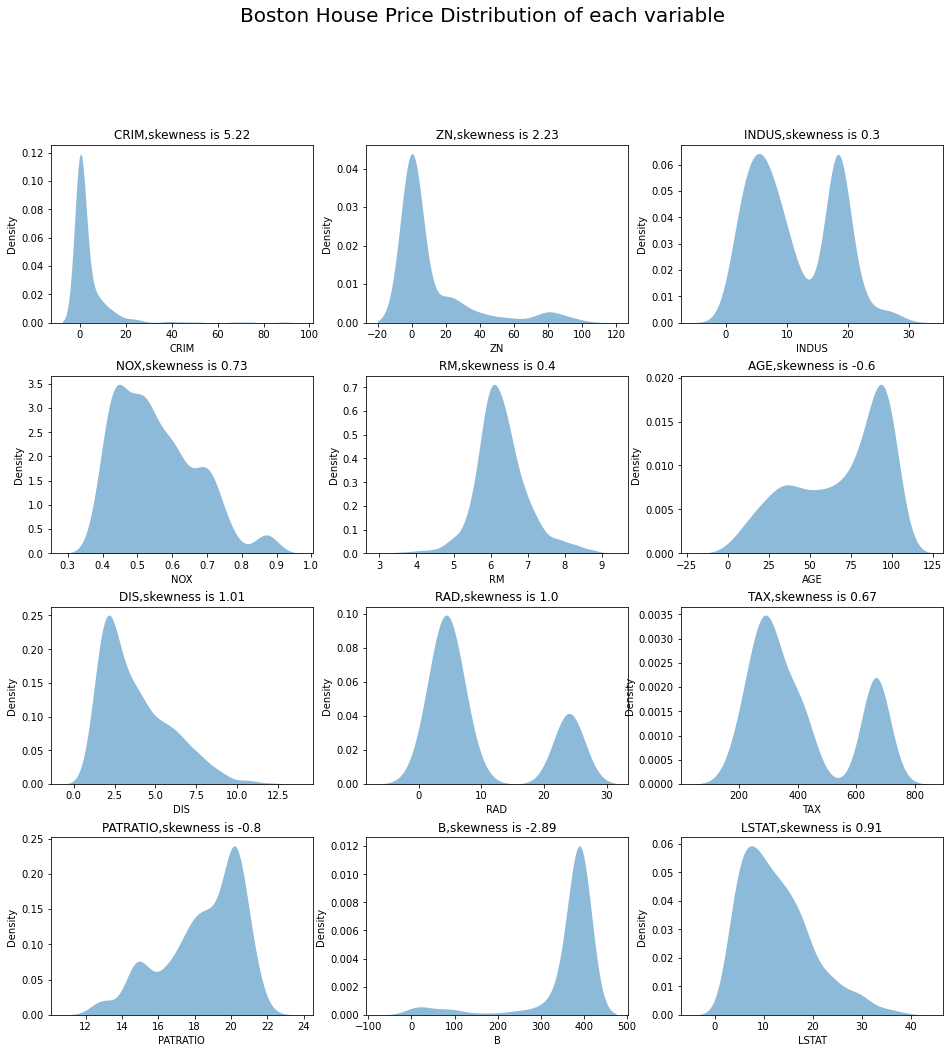

In [36]:
dist_check(dataset=raw_df,column_list=numeric_column,rows=4,cols=3,suptitle='Boston House Price Distribution of each variable')
plt.show()

## Data Pre-Processing

In [37]:
# Removing outliers
from collections import Counter
def IQR_method(df,n,features):
    outlier_list = []
    for column in features:
        # 1st quartile (25%)
        Q1 =  np.percentile(df[column],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # InterQuantile Range (IQR)
        IQR = Q3-Q1
        
        # outlier step 
        outlier_step = 1.5*IQR
        
        # Determining a list of indicies of outlier
        outlier_list_column = df[(df[column]<Q1 - outlier_step)|(df[column] > Q3+outlier_step)].index
        
        # appending the list of outliers
        outlier_list.extend(outlier_list_column)
        
    outlier_list = Counter(outlier_list)
    multiple_outliers = list(k for k,v in outlier_list.items() if v > n)
    
    # Number of Records below and above bound values
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers:', df1.shape[0]+df2.shape[0])
    return multiple_outliers
    
        

In [38]:
Outlier_IQR = IQR_method(raw_df,1,numeric_column)

Total number of deleted outliers: 7


In [39]:
# dropping outliers
df = raw_df.drop(Outlier_IQR,axis=0).reset_index(drop=True)


## Train_Test_Split

In [40]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

In [41]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state = 42)

## Feature Scaling

In [42]:
from sklearn.preprocessing import StandardScaler

def Standard_Scaler(df,col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [43]:
col_names = ['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD','TAX','PATRATIO','B','LSTAT']

x_train = Standard_Scaler(x_train,col_names)
x_test = Standard_Scaler(x_test,col_names)

## Comparing Different Models

### Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)


In [45]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [46]:
def Model_Eval (model,x_train,y_train,x_test,y_test,y_pred):
    
    # Adjusted r-square
    r2 = model.score(x_test,y_test)
    
    # number of observation shape along axis 0 
    n = x_test.shape[0]
    p = x_test.shape[1]
    
    # Adjusted r-squared formula
    adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
    
    cv_score = cross_val_score(estimator=model,X = x_train,y = y_train,cv = 10)
    cv_r2 = cv_score.mean()
 
    
    return r2,adjusted_r2,cv_r2,rmse
    
    
    

In [47]:
mat = [Model_Eval (lr,x_train,y_train,x_test,y_test,y_pred)]

lm_score = pd.DataFrame(data = mat,columns= ['R2 Score','Adjusted R2 Score','Cross Validation R2 Score','RMSE'])
lm_score.insert(0,'Model','Linear Regression')

lm_score


,Model,R2 Score,Adjusted R2 Score,Cross Validation R2 Score,RMSE
0,Linear Regression,0.65472,0.618227,0.67391,4.823995


### Decision Tree Regressor

In [48]:
# from sklearn.tree import DecisionTreeRegressor
# dtree = DecisionTreeRegressor(criterion= 'gini',random_state=1)
# dtree.fit(x_train,y_train)
# y_pred = dtree.predict(x_test)


### Ridge Regression

In [49]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=3,solver='cholesky')

In [50]:
ridge_model.fit(x_train,y_train)
y_pred = ridge_model.predict(x_test)

In [51]:
mat = [Model_Eval(ridge_model,x_train,y_train,x_test,y_test,y_pred)]

ridge_score = pd.DataFrame(data = mat,columns= ['R2 Score','Adjusted R2 Score','Cross Validation R2 Score','RMSE'])
ridge_score.insert(0,'Model','Ridge Regression')
ridge_score

,Model,R2 Score,Adjusted R2 Score,Cross Validation R2 Score,RMSE
0,Ridge Regression,0.6556,0.6192,0.677292,4.817844


### Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(n_estimators=100,random_state=1)

In [60]:
random_forest_model.fit(x_train,y_train)
y_pred = random_forest_model.predict(x_test)

In [61]:
mat = [Model_Eval(random_forest_model,x_train,y_train,x_test,y_test,y_pred)]

random_forest_score = pd.DataFrame(data = mat,columns= ['R2 Score','Adjusted R2 Score','Cross Validation R2 Score','RMSE'])
random_forest_score.insert(0,'Model','Random Forest Regressor')
random_forest_score

,Model,R2 Score,Adjusted R2 Score,Cross Validation R2 Score,RMSE
0,Random Forest Regressor,0.823268,0.804589,0.803472,3.451265


### XGBoost

In [55]:
from xgboost import XGBRegressor

XGBoost_model = XGBRegressor(n_estimators=1000,max_depth = 7,eta=0.1,subsample= 0.8,colsample_bytree = 0.8)

In [56]:
XGBoost_model.fit(x_train,y_train)
y_pred = XGBoost_model.predict(x_test)

In [57]:
mat = [Model_Eval(XGBoost_model,x_train,y_train,x_test,y_test,y_pred)]

xgboost_score = pd.DataFrame(data = mat,columns= ['R2 Score','Adjusted R2 Score','Cross Validation R2 Score','RMSE'])
xgboost_score.insert(0,'Model','XGBoost Regressor')
xgboost_score

,Model,R2 Score,Adjusted R2 Score,Cross Validation R2 Score,RMSE
0,XGBoost Regressor,0.771515,0.747366,0.826158,3.924192


## Final Model Evaluation

In [58]:
Final_eval = pd.concat([lm_score,ridge_score,random_forest_score,xgboost_score],ignore_index=True,sort = False)
Final_eval

,Model,R2 Score,Adjusted R2 Score,Cross Validation R2 Score,RMSE
0,Linear Regression,0.654720,0.618227,0.673910,4.823995
1,Ridge Regression,0.655600,0.619200,0.677292,4.817844
2,Random Forest Regressor,0.828335,0.810192,0.781168,3.401429
3,XGBoost Regressor,0.771515,0.747366,0.826158,3.924192
